In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [2]:
import tensorflow as tf

ImportError: No module named tensorflow

In [3]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
training_file = '/u/ki/swmclau2/des/PearceRedMagicXiChinchilla.hdf5'

em_method = 'nn'
split_method = 'random'

In [5]:
a = 1.0
z = 1.0/a - 1.0

In [6]:
fixed_params = {'z':z}

In [ ]:
emu = OriginalRecipe(training_file, method = em_method, fixed_params=fixed_params,
                    hyperparams = {'hidden_layer_sizes': (50, 25),
                                 'activation': 'relu', 'verbose': True, 
                                    'tol': 1e-8, 'learning_rate_init':1e-6,\
                                   'max_iter':5000, 'alpha':0, 'early_stopping':False, 'validation_fraction':0.3})

Iteration 1, loss = 0.55884262
Iteration 2, loss = 0.55711176
Iteration 3, loss = 0.55539760
Iteration 4, loss = 0.55369187
Iteration 5, loss = 0.55199096
Iteration 6, loss = 0.55029982
Iteration 7, loss = 0.54861613
Iteration 8, loss = 0.54693709
Iteration 9, loss = 0.54526709
Iteration 10, loss = 0.54360155
Iteration 11, loss = 0.54193883
Iteration 12, loss = 0.54028496
Iteration 13, loss = 0.53863472
Iteration 14, loss = 0.53699144
Iteration 15, loss = 0.53535335
Iteration 16, loss = 0.53372105
Iteration 17, loss = 0.53209432
Iteration 18, loss = 0.53047259
Iteration 19, loss = 0.52885792
Iteration 20, loss = 0.52724806
Iteration 21, loss = 0.52564389
Iteration 22, loss = 0.52404244
Iteration 23, loss = 0.52244569
Iteration 24, loss = 0.52085567
Iteration 25, loss = 0.51926896
Iteration 26, loss = 0.51768736
Iteration 27, loss = 0.51611002
Iteration 28, loss = 0.51453946
Iteration 29, loss = 0.51296938
Iteration 30, loss = 0.51140345
Iteration 31, loss = 0.50984750
Iteration 32, los

In [47]:
np.abs(emu.goodness_of_fit(training_file, statistic = 'log_frac')).mean()

0.6925740755155929

In [48]:
np.abs(emu.goodness_of_fit(training_file, statistic = 'frac')).mean()

0.47457371097790413

In [49]:
fit_idxs = np.argsort(gof.mean(axis = 1))

In [50]:
emu.goodness_of_fit(training_file).mean()#, statistic = 'log_frac')).mean()

0.8084320017686076

In [11]:
model = emu._emulator

In [12]:
ypred = model.predict(emu.x)

(array([  16.,   61.,  349., 1813., 7101., 7279., 2801.,  526.,  103.,
          21.]),
 array([-5.73653985, -4.9963066 , -4.25607335, -3.51584011, -2.77560686,
        -2.03537361, -1.29514036, -0.55490711,  0.18532614,  0.92555939,
         1.66579264]),
 <a list of 10 Patch objects>)

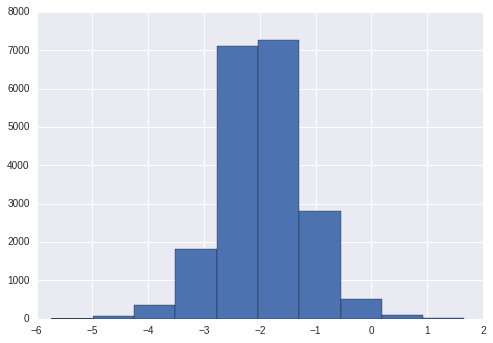

In [13]:
plt.hist( np.log10( (emu._y_std+1e-5)*np.abs(ypred-emu.y)/np.abs((emu._y_std+1e-5)*emu.y+emu._y_mean) ))

In [14]:
( (emu._y_std+1e-5)*np.abs(ypred-emu.y)/np.abs((emu._y_std+1e-5)*emu.y+emu._y_mean) ).mean()

0.07668232742688462

In [15]:
emu._y_mean, emu._y_std

(1.5815369709438643, 1.6059839151010196)

0.014968432315385213
[-0.00888088 -0.00431782  0.00023353 -0.00080377  0.00841895  0.0083527
  0.02155742  0.06301435  0.01097207 -0.02061797  0.00096528  0.00452048
 -0.00206946  0.00590953  0.0057665   0.00222424  0.00578069  0.00151791]


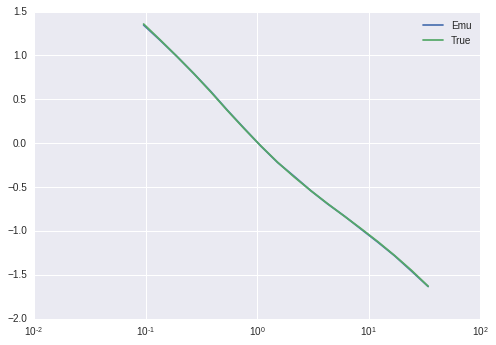

0.015392818048548354
[ 0.00100147  0.00039146 -0.00171467 -0.00095608  0.00283651  0.01531465
  0.11088048 -0.24657099 -0.01836436  0.00590923 -0.0042174   0.00086585
  0.00558128  0.00095222  0.00123112 -0.00168789  0.00417752 -0.0035858 ]


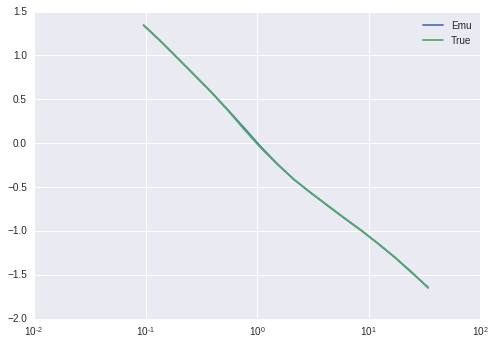

0.016036808112749004
[ 1.13197531e-05  8.40992596e-03  9.15399800e-03  1.75708027e-03
  3.64347703e-03 -5.12623939e-03 -2.28631672e-02 -1.93679167e+00
  3.42734946e-02 -3.54292299e-03 -7.35966853e-03 -8.37107697e-03
 -9.86496751e-03  1.13789893e-03  7.93385771e-04 -7.45952956e-04
  6.12595832e-03 -1.40536122e-04]


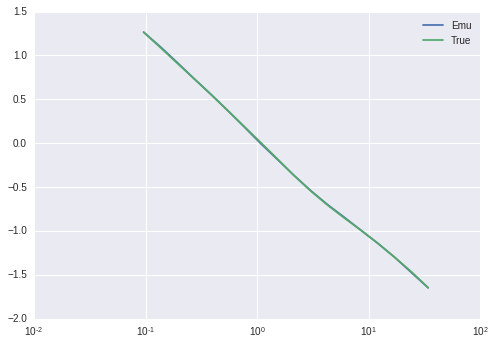

0.016038755026071962
[-0.01068284  0.00869494 -0.00031961 -0.00658717 -0.01818326 -0.10096829
  0.0098782   0.01536325  0.01731841  0.00546601 -0.00072859 -0.00693307
 -0.00617723  0.00228463  0.00225148  0.00217152  0.00694476  0.00496968]


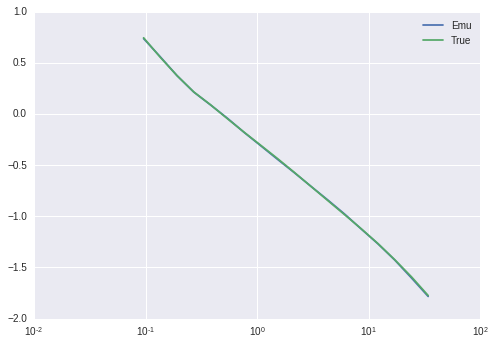

0.016624328416027585
[-0.00447631 -0.00213439  0.00138168  0.00039519  0.00524177 -0.00704914
  0.04182903 -0.06937303  0.03883554  0.01017486  0.01055877  0.00218175
 -0.00208705  0.0003658   0.00620121  0.0044092   0.0093343   0.00484858]


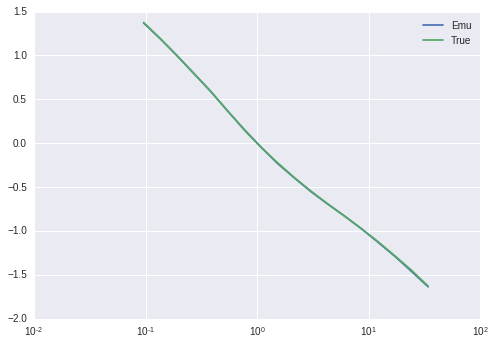

0.017257678744211136
[-2.27897633e-03  6.81119412e-03 -7.40116723e-04  1.92365656e-04
  5.35720209e-03  2.64143100e-05 -7.63843927e-03 -4.20670157e-02
  1.79202761e-01  1.63664114e-02 -6.91734134e-03 -1.65514349e-02
 -1.63902767e-02  3.17272009e-03  7.88063752e-03 -5.30321673e-04
  6.64775549e-03  7.25910875e-04]


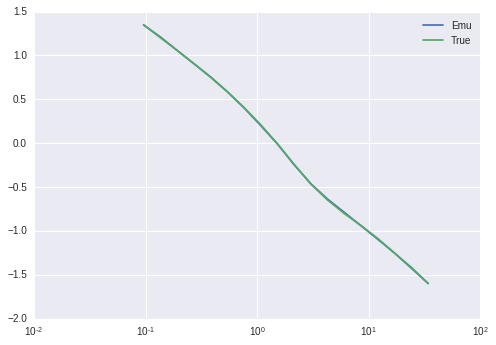

0.017453617447018295
[ 0.00029052  0.0028137  -0.00537531 -0.00945908 -0.00269117  0.00669495
 -0.00432178  0.05580818  0.05284856  0.02187687 -0.00544045 -0.00958866
 -0.00892028  0.00204296  0.0069314   0.00322127  0.00676166 -0.00241245]


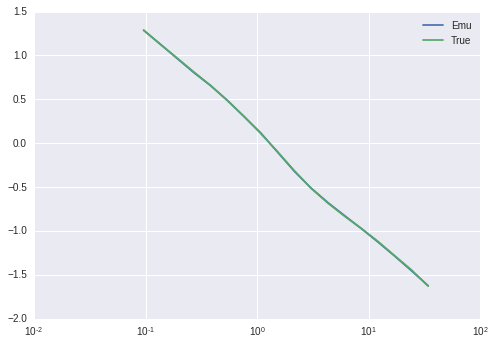

0.01835916819070541
[ 9.29993475e-03  1.38844937e-02 -8.49636687e-03  1.58030350e-02
  2.85376244e-02 -2.29274146e-01  2.84190099e-02  3.08630579e-02
  3.28271094e-02  5.00231736e-03  4.82485057e-03 -2.30397682e-03
  6.48516390e-03  2.39980247e-03 -1.53536835e-04  1.82202560e-03
 -6.53339408e-04 -7.61360950e-03]


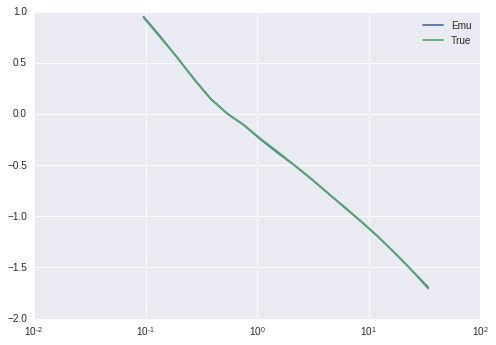

0.01840515932567443
[ 0.00406422 -0.00049215  0.00521201  0.00304535  0.0070222  -0.00742258
  0.01298594  0.08730694  0.01887489  0.03508712  0.02618283  0.00830936
  0.00796046  0.0033189   0.00400687 -0.00060695  0.00106269 -0.00682502]


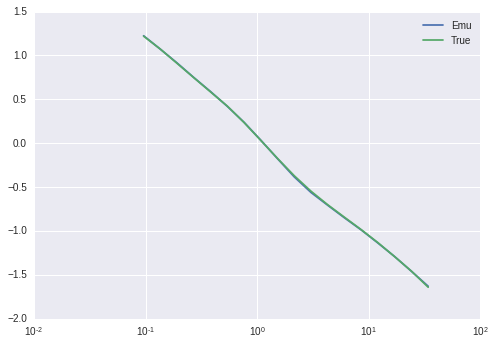

0.018632688507891886
[-1.87421614e-03 -2.67375961e-03  3.70804260e-03 -3.82842329e-04
 -1.49400740e-02  3.11980299e-03 -6.96101763e-03 -6.15439804e-03
  3.80093272e-02  5.46203354e-02  2.73241975e-02  9.58384437e-03
 -9.45898798e-03  8.07868600e-05  6.65493769e-03 -5.58371301e-04
  4.56966583e-03 -6.57901204e-03]


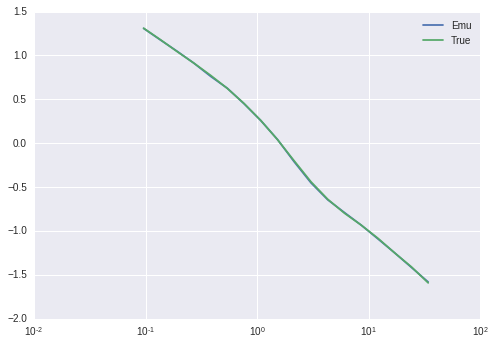

In [37]:
for idx in fit_idxs[:10]:
    print gof[idx].mean()
    print (ypred[idx*emu.n_bins:(idx+1)*emu.n_bins]-emu.y[idx*emu.n_bins:(idx+1)*emu.n_bins])/emu.y[idx*emu.n_bins:(idx+1)*emu.n_bins]
    plt.plot(emu.scale_bin_centers, ypred[idx*emu.n_bins:(idx+1)*emu.n_bins], label = 'Emu')
    plt.plot(emu.scale_bin_centers, emu.y[idx*emu.n_bins:(idx+1)*emu.n_bins], label = 'True')
    plt.legend(loc='best')
    plt.xscale('log')
    plt.show()

In [17]:
print dict(zip(emu.get_param_names(), emu.x[8*emu.n_bins, :]*emu._x_std+emu._x_mean))

{'logMmin': 12.587542192569046, 'f_c': 0.12031569794419092, 'logM0': 12.870439686228039, 'logM1': 14.86691458145175, 'r': -1.0185395291395554, 'sigma_logM': 0.5537623103025294, 'alpha': 1.070529116468207}


In [18]:
emu.get_param_names()

['logM1', 'logMmin', 'f_c', 'logM0', 'sigma_logM', 'alpha', 'r']

In [19]:
emu._ordered_params

OrderedDict([('logM1', (13.0, 15.0)),
             ('logMmin', (11.5, 13.5)),
             ('f_c', (0.01, 0.5)),
             ('logM0', (12.0, 16.0)),
             ('sigma_logM', (0.05, 0.6)),
             ('alpha', (0.8, 1.2)),
             ('r', (-1.1000000189853054, 1.6000000000507297))])

In [20]:
gof = emu.goodness_of_fit(training_file, statistic = 'frac')
print gof.mean()

0.04822822669460928


In [21]:
for row in gof:
    print row

[0.06415707 0.00490625 0.08439011 0.04104241 0.01628124 0.06369894
 0.07041218 0.01471942 0.02650418 0.00418093 0.02181407 0.05733324
 0.05285157 0.07609074 0.05953972 0.03847439 0.05413718 0.01257017]
[0.05293154 0.05607732 0.0379122  0.01424388 0.00778078 0.0201758
 0.00154294 0.02927312 0.00258268 0.03378466 0.02528351 0.01907837
 0.03185664 0.0095335  0.01001255 0.03343014 0.06831027 0.04695219]
[0.25453612 0.05705583 0.0385896  0.01862675 0.06431394 0.03768777
 0.04086813 0.00336508 0.02455846 0.03880034 0.09452835 0.0664273
 0.02819572 0.05349943 0.04102477 0.01103457 0.0484176  0.07595254]
[3.51087287e-02 1.24821950e-02 1.32092134e-02 2.87662592e-02
 4.95776384e-02 8.29015296e-03 1.06032674e-02 1.16092175e-02
 1.52715557e-03 4.44026139e-02 5.61850665e-02 2.26687706e-02
 3.73718877e-03 1.34722115e-02 2.55556770e-03 1.73299567e-02
 3.47478453e-02 1.71938411e-05]
[0.04793997 0.05819174 0.07455079 0.05420049 0.04380523 0.00332366
 0.02082567 0.01439937 0.00351859 0.00795096 0.023847

In [22]:
gof = emu.goodness_of_fit(training_file, statistic = 'frac')
print gof.mean()

0.04822822669460928


In [23]:
model = emu._emulator

In [24]:
model.score(emu.x, emu.y)

0.9995821442206786

In [25]:
ypred = model.predict(emu.x)

np.mean(np.abs(ypred-emu.y)/emu.y)

-0.1734201646776563

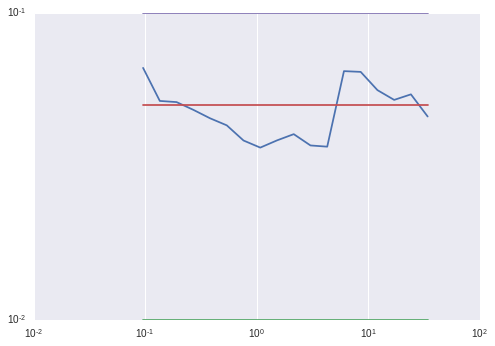

In [26]:
plt.plot(emu.scale_bin_centers, np.abs(gof.mean(axis = 0)) )
plt.plot(emu.scale_bin_centers, np.ones_like(emu.scale_bin_centers)*0.01)
plt.plot(emu.scale_bin_centers, np.ones_like(emu.scale_bin_centers)*0.05)
plt.plot(emu.scale_bin_centers, np.ones_like(emu.scale_bin_centers)*0.1)


plt.loglog();

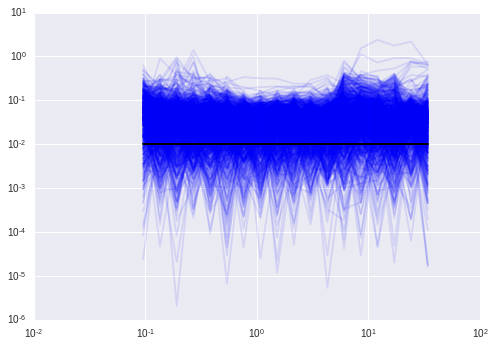

In [27]:
plt.plot(emu.scale_bin_centers, np.abs(gof.T),alpha = 0.1, color = 'b')
plt.plot(emu.scale_bin_centers, np.ones_like(emu.scale_bin_centers)*0.01, lw = 2, color = 'k')
plt.loglog();

In [28]:
gof[:,i].shape

NameError: name 'i' is not defined

In [ ]:
for i in xrange(gof.shape[1]):
    plt.hist(np.log10(gof[:, i]), label = str(i), alpha = 0.2);
    
plt.legend(loc='best')
plt.show()